# Boeing boeing: Dance Motion Detectionn #

## CNN version 0.2 Date: 2021.9.23 (Windows Version) ##

In [1]:
import os

import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Load Dateset ##

In [2]:
data_path = os.path.join(os.getcwd(), 'data')
print(data_path)
print(os.listdir(data_path))

C:\Users\sanat\Documents\Github_\CG4002_Capstone\ML\cnn\data
['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


In [3]:
# Load the whole data into a big dataset, this is for data/feature study prupose
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_types = list(activity_codes.keys())

print(folders)

for j in folders:
    #print('j',j)
    csv_list = glob(j + '\\*')
    for i in csv_list:
        label = j.split('\\')[-1].split('_')[0]
#         print(label)
        if activity_codes.get(label) == None:
#             sys.exit(0)
            continue
        df = pd.read_csv(i)
        df['activity'] = activity_codes[label]
        df['sub_num'] = i[len(j)+5:-4]
        expnum = np.zeros(df.shape[0])
        df_all_list.append(df)
# print(df_all_list)
df_all = pd.concat(df_all_list,axis=0)
df_all = df_all.drop('Unnamed: 0',axis=1)
print(df_all.shape)
print(df_all.columns)
print(df.head(5))

['C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_1', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_11', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_2', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\jog_16', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\jog_9', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\sit_13', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\sit_5', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\std_14', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\std_6', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_12', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_3', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_4', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_

## Feature extraction ##

Each sample will be divided into 180 windows, inside each window we calculate min max mean std mad in time domain
We will get a 180 * 30 'image'
We should get 360 such samples

In [4]:
win_count = 180
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '\\*')
    label = j.split('\\')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(i, usecols = ['gravity.x','gravity.y', 'gravity.z','userAcceleration.x','userAcceleration.y','userAcceleration.z'])
        segment_size = int(df.shape[0]/win_count)
        data_x = np.zeros((1, win_count, df.shape[1] * 5))
        data_y = np.zeros(1)
        for c in range(win_count):
            start_idx = c * segment_size
            end_idx = start_idx + segment_size
            temp_list = []
            means = df[start_idx:end_idx].mean().to_numpy()
            stds = df[start_idx:end_idx].mean().to_numpy()
            mins = df[start_idx:end_idx].min().to_numpy()
            maxs = df[start_idx:end_idx].max().to_numpy()
            mads = df[start_idx:end_idx].mad().to_numpy()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
            temp_list = np.concatenate(temp_list, axis = 0)
            data_x[0][c] = temp_list
            data_y[0] = activity_codes[label]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(360, 180, 30)
(360,)


## Train ##

In [5]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

259 72 29


In [6]:
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=6), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=6), dtype=tf.float32)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(29, 180, 30)
(29, 6)


In [10]:
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (180,30)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(input_shape = (180,30)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 178, 32)           2912      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 87, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 1s 32ms/step - loss: 1.7704 - accuracy: 0.2355 - val_loss: 1.5735 - val_accuracy: 0.2414
Epoch 2/15
9/9 [==============================] - 0s 13ms/step - loss: 1.5257 - accuracy: 0.3475 - val_loss: 1.3983 - val_accuracy: 0.2759
Epoch 3/15
9/9 [==============================] - 0s 12ms/step - loss: 1.3663 - accuracy: 0.4015 - val_loss: 1.2263 - val_accuracy: 0.5172
Epoch 4/15
9/9 [==============================] - 0s 11ms/step - loss: 1.1839 - accuracy: 0.5097 - val_loss: 1.0797 - val_accuracy: 0.5862
Epoch 5/15
9/9 [==============================] - 0s 11ms/step - loss: 0.9735 - accuracy: 0.6371 - val_loss: 0.9205 - val_accuracy: 0.7241
Epoch 6/15
9/9 [==============================] - 0s 10ms/step - loss: 0.8783 - accuracy: 0.6950 - val_loss: 0.8086 - val_accuracy: 0.7586
Epoch 7/15
9/9 [==============================] - 0s 11ms/step - loss: 0.8194 - accuracy: 0.6641 - val_loss: 0.8017 - val_accuracy: 0.6897
Epoch 8/15
9/9 [===========

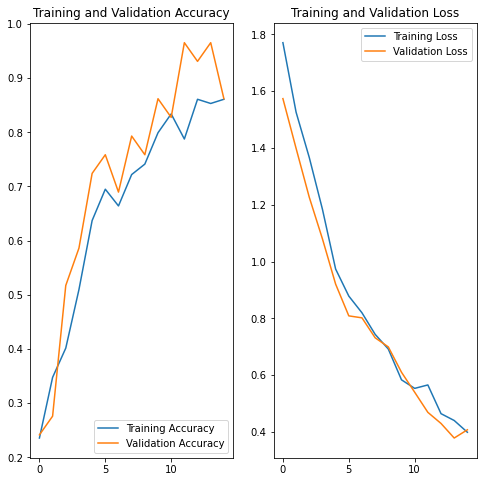

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save('cnn_trained.h5')

## Test ##

In [ ]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

In [15]:
print(model.trainable_weights)

[<tf.Variable 'conv1d/kernel:0' shape=(3, 30, 32) dtype=float32, numpy=
array([[[-0.05404992, -0.00732849, -0.0530129 , ..., -0.02294277,
          0.16759378,  0.15297768],
        [-0.12457941,  0.12596385, -0.12261737, ..., -0.17816336,
          0.19382364,  0.03648995],
        [ 0.13164218,  0.05630768, -0.13204376, ...,  0.04091522,
          0.13312855,  0.18400064],
        ...,
        [-0.19761711, -0.11605798,  0.06723537, ...,  0.00938992,
          0.08214475, -0.03182459],
        [ 0.03032581,  0.03943254,  0.11734478, ...,  0.12282449,
         -0.14345805, -0.1372491 ],
        [-0.01927285,  0.09391327, -0.13610117, ..., -0.15378602,
          0.15624607,  0.01543465]],

       [[-0.00497323, -0.07166956, -0.16372725, ..., -0.05886936,
          0.06086195,  0.08882628],
        [-0.04709472, -0.09200288,  0.13111687, ...,  0.06885688,
          0.00995929,  0.19363968],
        [ 0.1980125 , -0.19060628,  0.17451163, ..., -0.16269895,
         -0.08063134,  0.086783

In [21]:
# # Conv Layer (Kernel)
# print("{")
# first_3 = True
# for filter in model.trainable_weights[4].numpy():
#     if first_3 == False:
#         print(",", end="")
#     first_3 = False
#     print("{",end="")
#     first = True
#     for row in filter:
#         if first == False:
#             print(",", end="")
#         print("{" , end="")
#         first = False
        
#         first_2 = True
#         for val in row:
#             if first_2 == False:
#                 print(",", end="")
#             print(val , end="")
#             first_2 = False
#         print("}")
#     print("}")
#     print()
# print("};")

# Dense Layer (Kernel)
print("{")
first_3 = True
for filter in model.trainable_weights[8].numpy():
    if first_3 == False:
        print(",", end="")
    first_3 = False
    print("{",end="")
    first_2 = True
    for val in filter:
        if first_2 == False:
            print(",", end="")
        print(val , end="")
        first_2 = False
    print("}")
print("};")

# Bias (both conv & dense)
print("{",end="")
first = True
for val in model.trainable_weights[9].numpy():
    if first == False:
        print(",",end="")
    first = False
    print(val,end="")
print("};")


{
{0.3109153,0.24305242,-0.22623062,0.051146213,0.06135076,-0.15146932}
,{-0.21655189,0.015061799,0.09459609,0.108227134,-0.2607249,0.2166711}
,{-0.22301325,-0.21106037,-0.21323913,0.091943525,-0.07045965,0.22697696}
,{-0.12526461,-0.058089647,0.09359661,-0.29990247,0.01985605,0.086098224}
,{-0.2579406,-0.06751073,0.06691427,0.049169343,0.19730787,-0.095943324}
,{0.23623107,0.16561945,-0.32190153,-0.22444136,-0.14218733,0.21718255}
,{-0.24971049,0.17296788,0.29422614,0.28097242,0.10727576,-0.08590878}
,{-0.14662562,-0.35132155,-0.062181238,-0.13491671,0.2855144,-0.057371903}
,{-0.12599687,0.072002165,0.11745323,-0.30519727,0.04973607,0.19745547}
,{0.0031024918,0.27726018,-0.17962064,0.29983878,-0.27795258,-0.08560128}
,{0.02617505,-0.3206827,0.27720016,0.33463567,-0.17682476,-0.082442045}
,{-0.14565276,0.23721533,-0.18585868,0.07837742,-0.03683096,0.19224435}
,{0.17323062,-0.031394124,-0.19588016,-0.23992631,0.08409055,0.070864365}
,{-0.23784585,-0.30612487,0.021651462,0.21422783,0.057

In [ ]:
# print(test_dataset)

# model = tf.keras.models.load_model('cnn_trained.h5')
# model.summary()

model.evaluate(test_dataset,batch_size = BATCH_SIZE)

In [28]:
dataset_arr = {}
i = 0
for data in test_dataset:
    dataset = data[0]
    labels = data[1]
#     print(dataset.shape, labels.shape)
    l = len(dataset)
    for j in range(l):
#         print(dataset[i].shape, labels[i].shape)
        dataset_arr[i] = {'dataset': dataset[j].numpy().tolist(), 'label': labels[j].numpy().tolist()}
        i += 1
#     for val in data:
#         for i in range(len(val)):
#             print(val.numpy().shape,end=",")

print(len(dataset_arr))

72


In [29]:
import json

json_data = json.dumps(dataset_arr)

with open('test_data.json','w') as f:
    json.dump(dataset_arr, f, indent=4)
# print(json_data)